In [33]:
import gc
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import time
import math
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
from rerf.RerF import fastPredict, fastPredictPost, fastRerF
from rerf.rerfClassifier import rerfClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from tqdm import tqdm
import seaborn as sns

In [2]:
def combine_and_split(RS=0):
    ## Files downloaded from https://console.cloud.google.com/storage/quickdraw_dataset/full/numpy_bitmap
    f_fish = "full_numpy_bitmap_fish.npy"    
    f_flamingo = "full_numpy_bitmap_flamingo.npy"    
    f_firetruck = "full_numpy_bitmap_firetruck.npy"    

    fish = np.load(f_fish) 
    flamingo = np.load(f_flamingo) 
    firetruck = np.load(f_firetruck)

    X = np.vstack([fish,flamingo, firetruck])
    y = np.asarray(fish.shape[0]*[0] + flamingo.shape[0]*[1] + firetruck.shape[0]*[2])
    
    return(X,y)

def strat_split(X, y, RS = 0):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)
    sss.get_n_splits(X, y)
    
    for train_index, test_index in sss.split(X, y):
        print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

    return({'X_train':X_train, 'X_test':X_test, 'y_train':y_train, 'y_test':y_test})


In [3]:
X,y = combine_and_split(RS=1)
d = strat_split(X,y,RS=0)

TRAIN: [ 99252 394543 192695 ... 384310 127692 277570] TEST: [ 21847 445512  21316 ... 145002 325602 434358]


In [4]:
d

{'X_train': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'X_test': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'y_train': array([0, 2, 1, ..., 2, 0, 2]),
 'y_test': array([0, 2, 0, ..., 1, 2, 2])}

In [41]:
## Setup for run
num_runs = 1
#names = {"3-Nearest-Neighbors": "blue", "sklearn-RF":"#35B779FF",\
#        "ND-RerF-control":"purple", "ND-RF":"#f86000", "RerF": "black", "S-RerF":"#ff0000"}

names = {"S-RerF":"#ff0000",
         "sklearn-RF":"#35B779FF",
         "ND-RerF-control":"purple",
         "ND-RF":"#f86000", 
         "RerF": "black"}

n_est = 100
n_test = 10000
ns = [10,100,1000,5000]
ncores = 1
mx = 6
mn = 1

classifiers = [
    rerfClassifier(
        projection_matrix="S-RerF", 
        max_features = 28,
        n_estimators=n_est,
        n_jobs=ncores,
        image_height=28, 
        image_width=28, 
        patch_height_max=mx,
        patch_width_max=mn,
        patch_height_min=mx,
        patch_width_min=mn,
        ),
    RandomForestClassifier(n_estimators=n_est, max_features=28, n_jobs=ncores),
    rerfClassifier(n_estimators = n_est, projection_matrix = "RerF", 
        max_features = math.ceil(28*2.5*2.5), n_jobs = ncores),
    rerfClassifier(n_estimators = n_est, projection_matrix = "Base", 
        max_features = 28, n_jobs = ncores),
    rerfClassifier(n_estimators = n_est, projection_matrix = "RerF",
        max_features = 28, n_jobs = ncores),
    ]

In [42]:
d['X_test'].shape

(239707, 784)

In [43]:
# iterate
## Prep output file:

write_path = 'runs_quick_draw.csv'

X_test = d['X_test'][0:n_test, ::]
y_test = d['y_test'][0:n_test]

with open(write_path, 'w') as f:
    f.write("classifier,n,Lhat,trainTime,testTime,iterate\n")

runList = [(n, clf, iterate) for n in ns\
                             for clf in zip(classifiers, [key for key in names])\
                             for iterate in range(1, num_runs + 1)]

for n, clf, iterate in tqdm(runList):
    #print(f"iterate: {iterate}\t n: {n}\t classifier: {clf[1]}")
    gc.collect()
    X = d['X_train'][0:n, ::]
    y = d['y_train'][0:n]

    trainStartTime = time.time()
    clf[0].fit(X, y)
    trainEndTime = time.time()
    trainTime = trainEndTime - trainStartTime

    
    testStartTime = time.time()
    out = clf[0].predict(X_test)
    testEndTime = time.time()
    testTime = testEndTime - testStartTime

    lhat = np.mean(np.not_equal(out, y_test).astype(int))


    ####("variable,Lhat,trainTime,testTime,iterate")
    with open(write_path, 'a') as f:
        f.write(f"{clf[1]}, {n}, {lhat:2.9f}, {trainTime:2.9f}, {testTime:2.9f}, {iterate}\n")

    gc.collect()

100%|██████████| 20/20 [01:47<00:00, 13.58s/it]


In [9]:
# iterate
## Prep output file:
fname = 'runs_quick_draw.csv'

with open(fname, 'w') as f:
    f.write("classifier,n,Lhat,trainTime,testTime,iterate\n")

n = 100
iterate = 1
X = d['X_train'][0:n, ::]
y = d['y_train'][0:n]

trainStartTime = time.time()
clf[0].fit(X, y)
trainEndTime = time.time()
trainTime = trainEndTime - trainStartTime

testStartTime = time.time()
out = clf[0].predict(X_test)
testEndTime = time.time()
testTime = testEndTime - testStartTime

lhat = np.mean(np.not_equal(out, y_test).astype(int))


####("variable,Lhat,trainTime,testTime,iterate")
with open(fname, 'a') as f:
    f.write(f"'S-RerF', {n}, {lhat:2.9f}, {trainTime:2.9f}, {testTime:2.9f}, {iterate}\n")

NameError: name 'clf' is not defined

In [ ]:
# iterate
## Prep output file:
fname = 'runs_quick_draw.csv'

num_runs = 1
ns = [200000]

#with open(fname, 'w') as f:
#    f.write("classifier,n,Lhat,trainTime,testTime,iterate\n")


runList = [(n, clf, iterate) for n in ns\
                             for clf in zip(classifiers, [key for key in names])\
                             for iterate in range(1, num_runs + 1)]

for n, clf, iterate in runList:
        #print(f"iterate: {iterate}\t n: {n}\t classifier: {clf[1]}")
        gc.collect()
        X = X_train[0:n, ::]
        y = y_train[0:n]

        trainStartTime = time.time()
        clf[0].fit(X, y)
        trainEndTime = time.time()
        trainTime = trainEndTime - trainStartTime

        testStartTime = time.time()
        out = clf[0].predict(X_test)
        testEndTime = time.time()
        testTime = testEndTime - testStartTime

        lhat = np.mean(np.not_equal(out, y_test).astype(int))


        ####("variable,Lhat,trainTime,testTime,iterate")
        with open(fname, 'a') as f:
            f.write(f"{clf[1]}, {n}, {lhat:2.9f}, {trainTime:2.9f}, {testTime:2.9f}, {iterate}\n")
            
        gc.collect()


In [44]:
dat = pd.read_csv(write_path)

d1 = pd.DataFrame(columns = ['classifier', 'n', 'Lhat', 'color'])

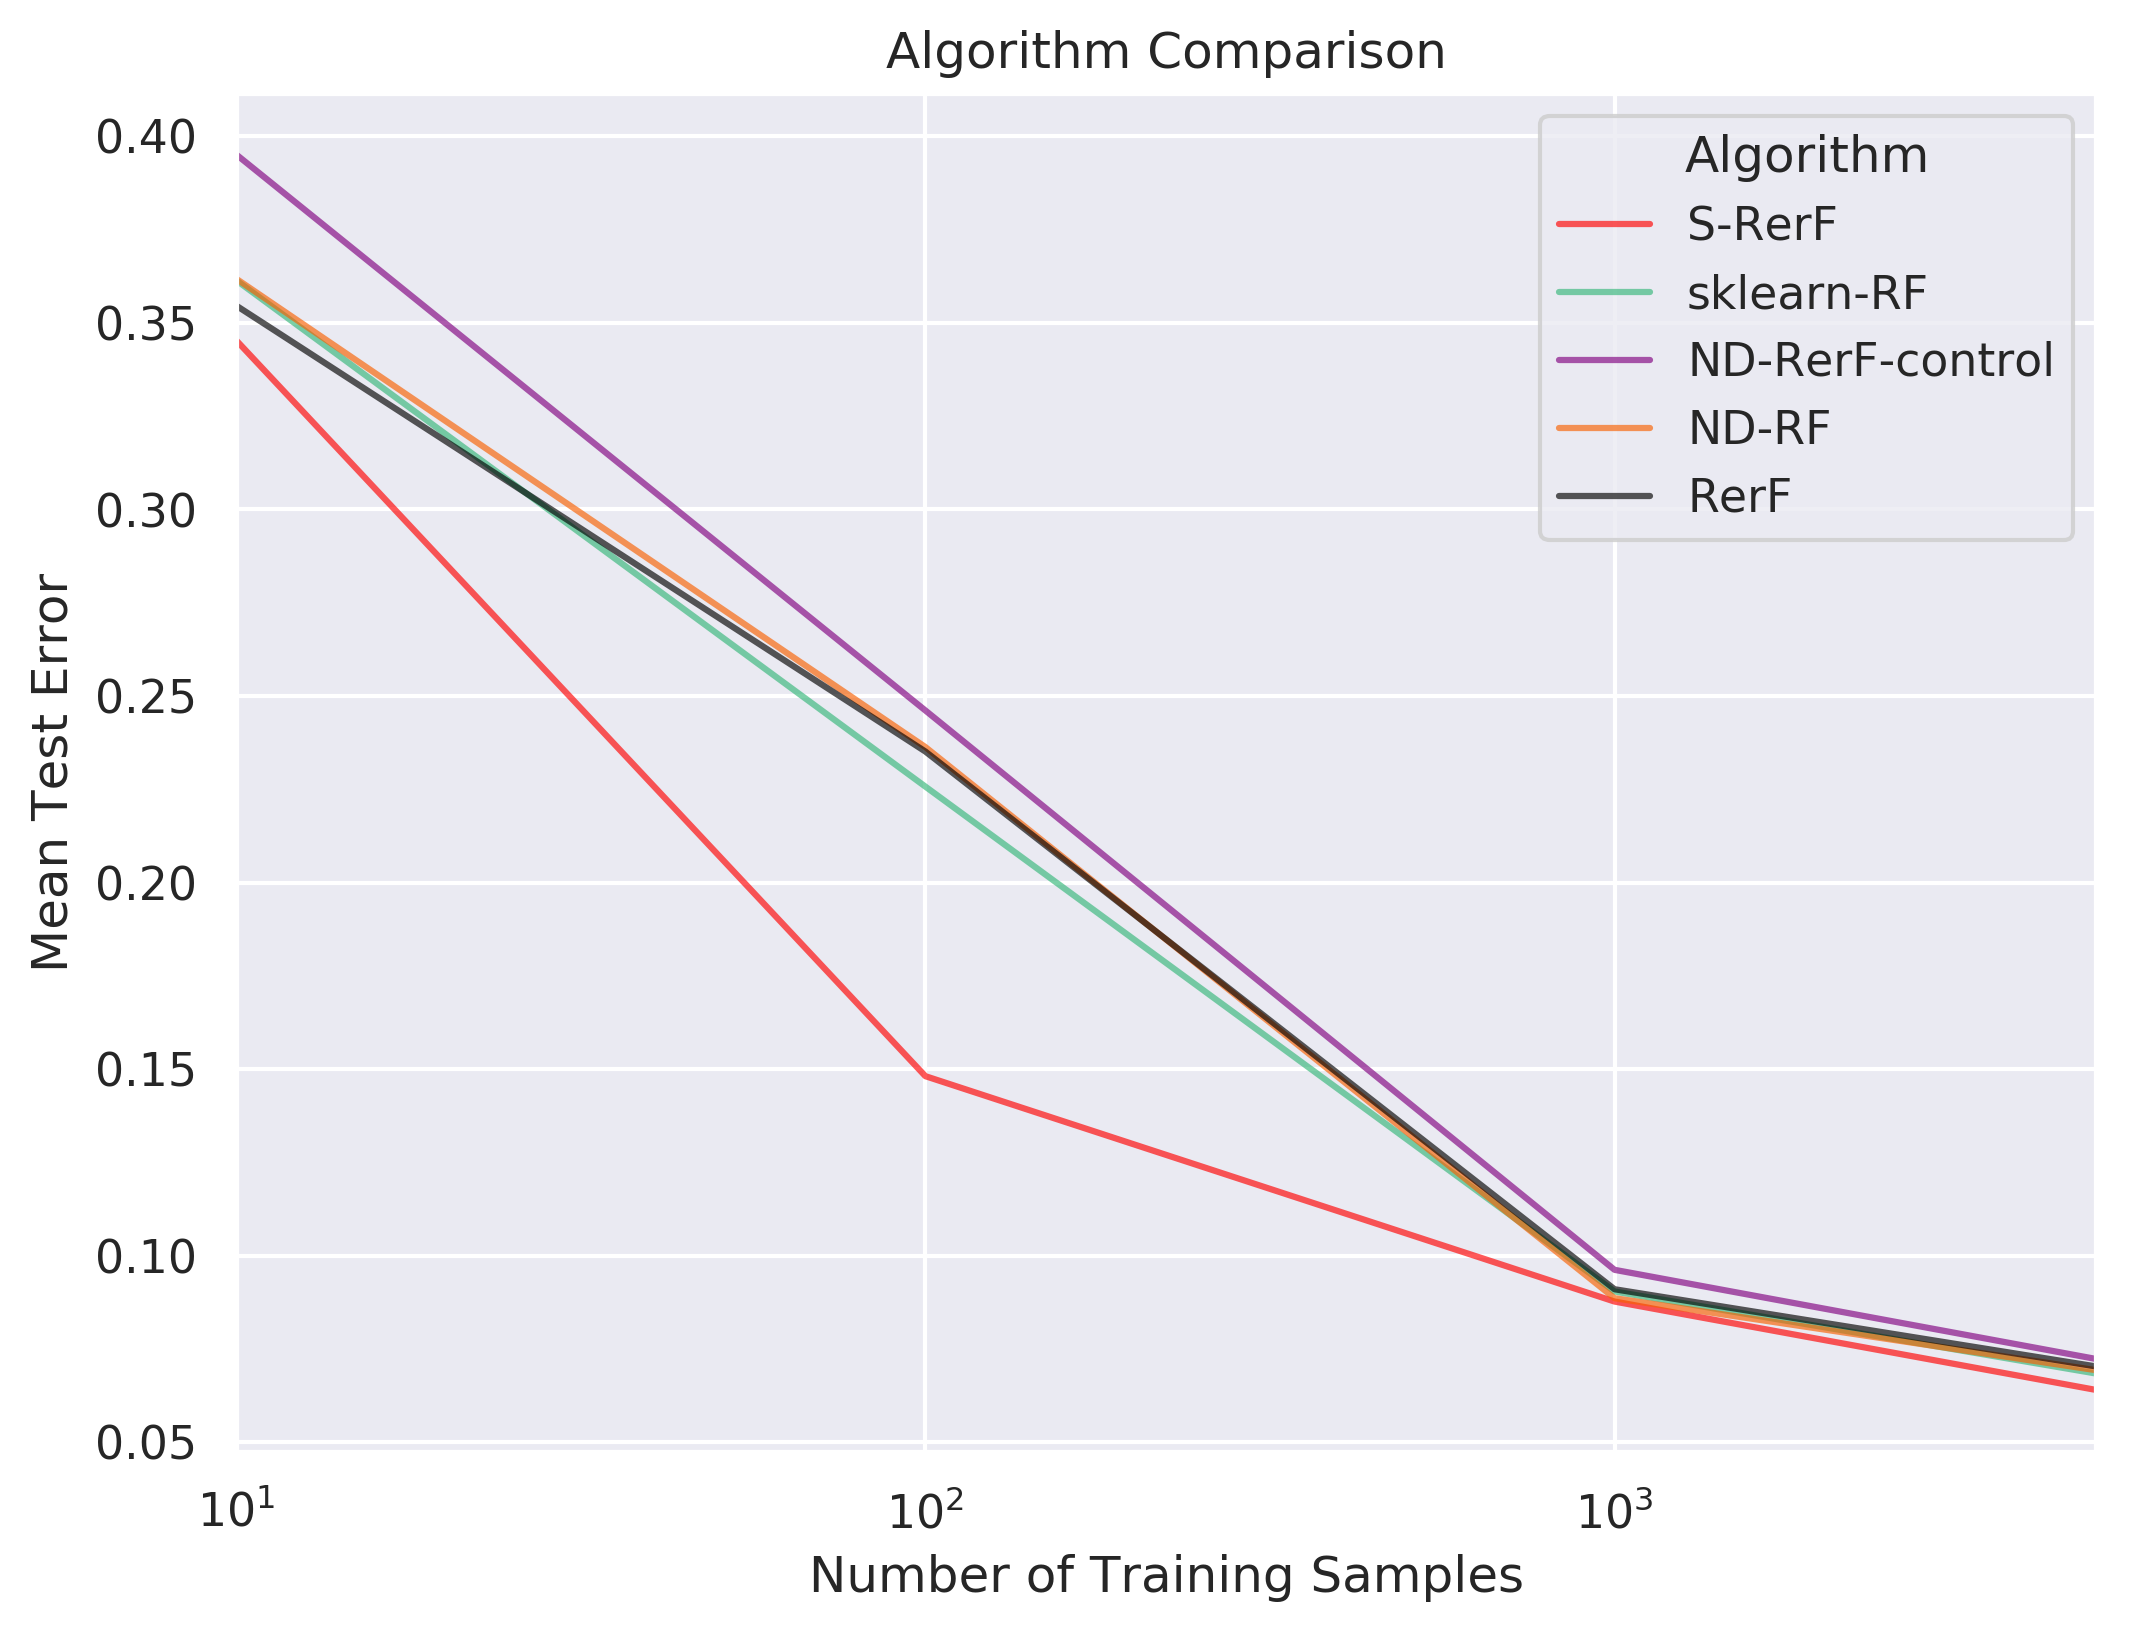

In [45]:
## Plot

k = 0
for ni in np.unique(dat['n']):
    for cl in np.unique(dat['classifier']):

        tmp = dat[np.logical_and(dat['classifier'] == cl,dat['n'] == ni)][['n', 'Lhat']]

        #se = stats.sem(tmp['Lhat'])

        list(tmp.mean())
        d1.loc[k] = [cl] + list(tmp.mean()) + [names[cl]]
        k += 1


sns.set(style="darkgrid", rc={'figure.figsize':[6,4], 'figure.dpi': 300})
fig, ax = plt.subplots(figsize = (8,6))

for key in names.keys():
    grp = d1[d1['classifier'] == key]
    ax = grp.plot(ax=ax, kind='line', x='n', y='Lhat', label=key, \
            c = names[key], alpha =0.65)
    ax.set_xscale('log')

plt.legend(loc='upper right',title='Algorithm')
plt.title('Algorithm Comparison')
plt.ylabel('Mean Test Error')
plt.xlabel('Number of Training Samples')
#plt.savefig(sim_dir / 'quickdraw_experiment.pdf',dpi=300,format='pdf')
plt.show()